# Implementing a concept-level reference game with EGG
In this tutorial, you will learn how to implement a concept-level reference game with EGG. The concept-level reference game was used in publications and theses. It can be modified, adapted and extended depending on the specific research question. This notebook implements the baseline implementation and the context-aware vs. context-unaware training used in [Kobrock et al. (2024)](https://aclanthology.org/2024.lrec-main.339/). Note that the settings and training presented in this tutorial are the same as in `train.py`. However, it is simplified and only works for one run. Please use the training provided in the repository to make full use of the model. For the same reasons, this tutorial notebook is accompanied by simplied versions of the `archs.py` and `dataset.py`. These simplied versions can be used for the context-aware vs. context-unaware simulations. The [`emergent-abstractions`](https://github.com/kristinakobrock/emergent-abstractions/tree/main) repository contains many more settings and game configurations to choose from.

## Installing dependencies
We used Python 3.9.15 and PyTorch 1.13.0. Generally, the minimal requirements are Python 3.6 and PyTorch 1`.1.0. requirements.txt lists the python packages needed to run this code. Additionally, please make sure you install EGG following the instructions [here](https://github.com/facebookresearch/EGG/tree/main#).

1. (optional) Create a new conda environement:
`conda create --name emergab python=3.9`
`conda activate emergab`
2. EGG can be installed as a package to be used as a library (see [here](https://github.com/facebookresearch/EGG/tree/main#) for more options):
`pip install git+https://github.com/facebookresearch/EGG.git`
3. Install packages from the requirements file:
`pip install -r requirements.txt`

In [1]:
# import Python packages
from argparse import Namespace
import torch
# print(torch.__version__)
# import torch.utils.data
import torch.nn as nn
import egg.core as core
import os
import pickle
import itertools
import yaml

# import modules from files
import dataset
from archs import Sender, Receiver
from language_analysis_local import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

opts = core.init(params=['--random_seed=7', # will initialize numpy, torch, and python RNGs
                         '--lr=1e-3',   # sets the learning rate for the selected optimizer 
                         '--batch_size=32',
                         '--optimizer=adam'])

def load_config(path: str) -> Namespace:
    """Read a yaml file and return an argparse.Namespace."""
    with open(path, 'r') as f:
        cfg_dict = yaml.safe_load(f)          # → plain dict
    return Namespace(**cfg_dict) 

# dataset split
SPLIT = (0.6, 0.2, 0.2)

## Configurations
The file `config.yml` contains the configurations for running a simulation with the concept-level reference game. You can adapt them directly in the file and load them with the following line:

In [2]:
opts = load_config('config.yml') 

Additionally, the vocabulary size and message length need to be set. In the original code, we set the vocabulary size based on the number of values in a dataset and a scaling factor. Here, we assume that the vocabulary size is directly set in the `config.yml`. The maximum message lenght, i.e. the upper bound of numbers of symbols in one message is also specified by the user. If it is not specified, it is automatically set to the number of attributes + the end of sequence symbol.

In [3]:
# vocab size and message length
opts.dimensions = list(itertools.repeat(opts.values, opts.attributes))
vocab_size = opts.vocab_size_user
print("vocab size", vocab_size)
# allow user to specify a maximum message length
if opts.max_mess_len > 0:
    max_len = opts.max_mess_len
# default: number of attributes
else:
    max_len = len(opts.dimensions)
print("message length", max_len)

vocab size 16
message length 3


## Preparations 
Next, we set up a folder structure for saving where we can save each run according to its game specifications. This can be adopted and extended for different game settings. If the run should be saved, then first a `params.pkl` file is created that saves the configurations.

In [4]:
# set up folders for saving
if not os.path.exists('data'):
        os.makedirs('data')
if not os.path.exists('results'):
    os.makedirs('results')
    
data_set_name = '(' + str(len(opts.dimensions)) + ',' + str(opts.dimensions[0]) + ')'
folder_name = (data_set_name + '_game_size_' + str(opts.game_size))
folder_name = os.path.join("results", folder_name)

# define game setting from args
if opts.context_unaware:
    opts.game_setting = 'context_unaware'
else:
    opts.game_setting = 'context_aware'

# create subfolders if necessary
opts.game_path = os.path.join(opts.path, folder_name, opts.game_setting)
if not os.path.exists(opts.game_path):
    os.makedirs(opts.game_path)

# saving
if opts.save:
    # make folder for new run
    latest_run = len(os.listdir(opts.game_path))
    opts.save_path = os.path.join(opts.game_path, str(latest_run))
    if not os.path.exists(opts.save_path):
        os.makedirs(opts.save_path)
    pickle.dump(opts, open(opts.save_path + '/params.pkl', 'wb'))
    save_epoch = opts.n_epochs
else:
    save_epoch = None

## Dataset
The dataset is a symbolic dataset that is created in the dataset module. The dimensions are given by the numbers of attributes and values each object in the dataset has. The dataset can be used for simulating a concept-level reference game or a single object reference game. The latter can be achieved by setting `opts.game_size=1`. Here, we use `opts.game_size=10`, i.e. in each round of the game, speakers and listeners need to communicate about 10 objects that together form a target concept which needs to be discriminated from 10 distractors. There is also an option to load a pre-created dataset to save time if multiple runs with the same configuration need to be trained. The dataset is implemented based on the torch DataSet class, so it can be loaded with the PyTorch DataLoader.

In [5]:
# Dataset
# generate if not given
if not opts.load_dataset:
    data_set = dataset.DataSet(opts.dimensions,
                               game_size=opts.game_size,
                               scaling_factor=opts.scaling_factor,
                               device=device)
else:
    data_set = torch.load(opts.path + 'data/' + opts.load_dataset)
    print('data loaded from: ' + 'data/' + opts.load_dataset)
        
train, val, test = data_set

dimensions = train.dimensions

train = torch.utils.data.DataLoader(train, batch_size=opts.batch_size, shuffle=True)
val = torch.utils.data.DataLoader(val, batch_size=opts.batch_size, shuffle=False, drop_last=True)
test = torch.utils.data.DataLoader(test, batch_size=opts.batch_size, shuffle=False)

Creating train_ds and val_ds...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:02<00:00, 35.79it/s]



Creating test_ds...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 35.40it/s]


## Game
For the game, we need the training objective, or loss, the sender and receiver (speaker and listener) and we initialize a game class from EGG. Here, we use `core.RnnSenderGS`, `core.RnnReceiverGS` and the `core.SenderReceiverRnnGS` wrapper which is used to train RNN agents with the Gumbel-softmax relaxation. The RnnGS wrappers allow for messages consisting of multiple symbols. EGG offers more wrappers for other game configurations, e.g. using single-symbol messages or training with REINFORCE. Check out the EGG documentation!

In [6]:
def loss(_sender_input, _message, _receiver_input, receiver_output, labels, _aux_input):
    """
    Loss needs to be defined for gumbel softmax relaxation.
    For a discriminative game, accuracy is computed by comparing the index with highest score in Receiver
    output (a distribution of unnormalized probabilities over target positions) and the corresponding 
    label read from input, indicating the ground-truth position of the target.
    Adaptation to concept game with multiple targets after Mu & Goodman (2021) with BCEWithLogitsLoss
        receiver_output: Tensor of shape [batch_size, n_objects]
        labels: Tensor of shape [batch_size, n_objects]
    """
    loss_fn = nn.BCEWithLogitsLoss()
    loss = loss_fn(receiver_output, labels)
    receiver_pred = (receiver_output > 0).float()
    per_game_acc = (receiver_pred == labels).float().mean(1).cpu().numpy()  # all labels have to be predicted correctly
    acc = per_game_acc.mean()
    return loss, {'acc': acc}

In [7]:
# Game
# initialize sender and receiver agents
sender = Sender(opts.hidden_size, sum(dimensions), opts.game_size, opts.context_unaware)
receiver = Receiver(sum(dimensions), opts.hidden_size)

# initialize game
sender = core.RnnSenderGS(sender,
                          vocab_size,
                          int(opts.hidden_size / 2),
                          opts.hidden_size,
                          cell=opts.sender_cell,
                          max_len=max_len,
                          temperature=opts.temperature)

receiver = core.RnnReceiverGS(receiver,
                              vocab_size,
                              int(opts.hidden_size / 2),
                              opts.hidden_size,
                              cell=opts.receiver_cell)

game = core.SenderReceiverRnnGS(sender, receiver, loss, length_cost=opts.length_cost)

You can look at the game, sender and receiver configurations by printing them here, e.g.:

In [8]:
sender

RnnSenderGS(
  (agent): Sender(
    (fc1): Linear(in_features=120, out_features=128, bias=True)
    (fc2): Linear(in_features=120, out_features=128, bias=True)
    (fc3): Linear(in_features=256, out_features=128, bias=True)
  )
  (hidden_to_output): Linear(in_features=128, out_features=16, bias=True)
  (embedding): Linear(in_features=16, out_features=64, bias=True)
  (cell): GRUCell(64, 128)
)

## Training
For training, we use the Adam optimizer and the learning rate specified in the `config.yml`. We specify callbacks for saving and printing to console and initialize the EGG `core.Trainer`. If the same configuration was trained and saved already, the model can be loaded from checkpoint. Else, the model is trained.

In [9]:
# Training
# set optimizer
optimizer = torch.optim.Adam([
    {'params': game.sender.parameters(), 'lr': opts.learning_rate},
    {'params': game.receiver.parameters(), 'lr': opts.learning_rate}
])

# setup training and callbacks
# results/ data set name/ kind_of_dataset/ run/
callbacks = [SavingConsoleLogger(print_train_loss=True, as_json=True,
                                 save_path=opts.save_path, save_epoch=save_epoch),
             core.TemperatureUpdater(agent=sender, decay=opts.temp_update, minimum=0.5)]
if opts.save:
    callbacks.extend([core.callbacks.InteractionSaver([opts.n_epochs],
                                                      test_epochs=[opts.n_epochs],
                                                      checkpoint_dir=opts.save_path),
                      core.callbacks.CheckpointSaver(opts.save_path, checkpoint_freq=0)])

trainer = core.Trainer(game=game, optimizer=optimizer,
                       train_data=train, validation_data=val, callbacks=callbacks, device=device)

# if checkpoint path is given, load checkpoint and skip training
if opts.load_checkpoint:
    trainer.load_from_checkpoint(opts.checkpoint_path, map_location=device)
else:
    trainer.train(n_epochs=opts.n_epochs)

{"loss": 0.6897689700126648, "acc": 0.5346396565437317, "length": 2.652470111846924, "mode": "train", "epoch": 1}
{"loss": 0.6530416011810303, "acc": 0.6418973207473755, "length": 2.3489582538604736, "mode": "test", "epoch": 1}
{"loss": 0.5722824931144714, "acc": 0.7047596573829651, "length": 2.960218906402588, "mode": "train", "epoch": 2}
{"loss": 0.5150803327560425, "acc": 0.771842360496521, "length": 3.5364582538604736, "mode": "test", "epoch": 2}
{"loss": 0.46780309081077576, "acc": 0.7909306287765503, "length": 3.685641050338745, "mode": "train", "epoch": 3}
{"loss": 0.4964481592178345, "acc": 0.7909723520278931, "length": 4.0, "mode": "test", "epoch": 3}
{"loss": 0.4179738163948059, "acc": 0.8121713399887085, "length": 3.962944507598877, "mode": "train", "epoch": 4}
{"loss": 0.537422776222229, "acc": 0.7451388835906982, "length": 4.0, "mode": "test", "epoch": 4}
{"loss": 0.36993408203125, "acc": 0.8387147784233093, "length": 3.9874427318573, "mode": "train", "epoch": 5}
{"loss": 

The `SavingConsoleLogger` callback is defined in `language_analysis_local`. It prints the loss, accuracy and effective message length for each epoch in training and validation (here called "test") mode. After training, the performance is evaluated once on the test dataset:

In [10]:
# after training evaluate performance on the test data set
if len(test):
    trainer.validation_data = test
    eval_loss, interaction = trainer.eval()
    acc = torch.mean(interaction.aux['acc']).item()
    print("test accuracy: " + str(acc))
    if opts.save:
        loss_and_metrics_path = os.path.join(opts.save_path, 'loss_and_metrics.pkl')
        if os.path.exists(loss_and_metrics_path):
            with open(loss_and_metrics_path, 'rb') as pickle_file:
                loss_and_metrics = pickle.load(pickle_file)
            print("In the write file section")
        else:
            loss_and_metrics = {}

        loss_and_metrics['final_test_loss'] = eval_loss
        loss_and_metrics['final_test_acc'] = acc
        pickle.dump(loss_and_metrics, open(loss_and_metrics_path, 'wb'))

test accuracy: 0.7927868366241455
In the write file section


In [11]:
opts.save_path

'results\\(3,4)_game_size_10\\context_aware\\0'

# Results and analysis
If you have saved the results, then a folder which specifies the most important game configurations is created in the results folder. The results for each run consist of the following parts:
- `params.pkl`: File which saves the run configurations
- `loss_and_metrics.pkl`: File which saves the loss, accuracy, and message length metrics similar to the console output during training
- `final.tar`: The trained model which can be loaded with opts.load_checkpoint
- The `interactions` folder which consists of train and validation interactions (optionally also test interactions). By default, the interactions of the final epoch are saved. We'll see how to analyze the interactions below.

## Model performance
Now, we can turn to the analysis. The first step is always to look at the model performance to see whether the model was trained and achieved a satisfying performance.

In [12]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('default')
import random
import seaborn

from utils.load_results import *
from utils.plot_helpers import *
from utils.analysis_from_interaction import *

In [13]:
paths = [folder_name] # 'results/(3,4)_game_size_10'

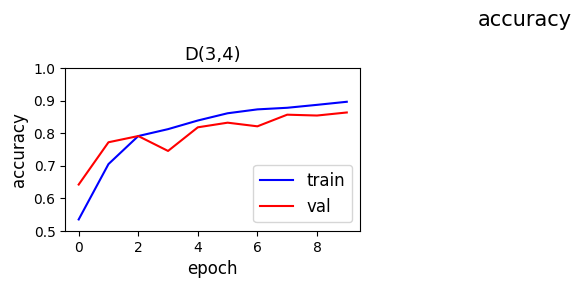

In [14]:
all_accuracies = load_accuracies(paths, n_runs=1, n_epochs=opts.n_epochs, val_steps=1, context_unaware=False)
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], ylim=(0.5, 1), steps=(1, 1), n_epochs=10, plot_indices=(1,))

We can also plot how the message length varies during training.

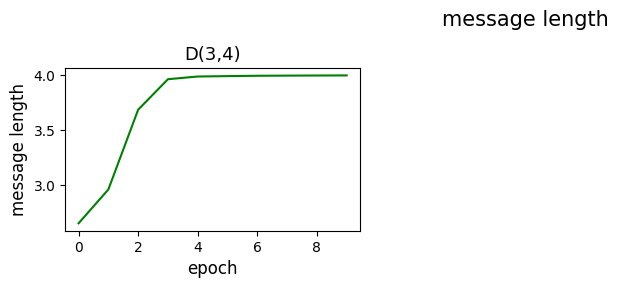

In [15]:
plot_training_trajectory(all_accuracies['train_acc'], all_accuracies['val_acc'], message_length_train=all_accuracies['train_message_lengths'], message_length_val=all_accuracies['val_message_lengths'], steps=(1, 1), n_epochs=10, plot_indices=(1,), message_length_plot=True, train_only=True)

## Interactions
Next, let's look at the saved interactions. Using the interactions, we can do a qualitative analysis of the messages produced for the concepts in the dataset or use them to compute quantitative metrics.
An interaction consists of the following parts:
- sender_input: The input to the sender, i.e. objects in the dataset (one-hot encoded)
- receiver_input: Same for the receiver input
- labels: These are the true labels that the receiver output needs to be compared to
- aux_input: Optional auxiliary input (here empty)
- message: The message that was sent by the sender (as logits)
- receiver_output: The receiver predictions (labels for the objects)
- message_length: The length of the messages sent by the sender
- aux: An optional dictionary, here we save the console output (accuracy, loss, length)

### Qualitative analysis
In the emergent-abstractions repository, `analyis_qualitative.ipynb` provides examples for a qualitative analysis. Here are examples for how to reconstruct the input and message from the saved interactions.

In [16]:
try:
    # only works if opts.save = True
    path = opts.save_path
except AttributeError:
    path = 'results/(3,4)_game_size_10/context_aware/0'

In [17]:
path_to_interaction_train = (path + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')
interaction = torch.load(path_to_interaction_train, weights_only=False)

To look at the messages, we need to argmax the logits:

In [18]:
messages = interaction.message.argmax(dim=-1)
messages = [msg.tolist() for msg in messages]
print(messages[0])

[12, 9, 11, 0]


To look at the concepts, we need to de-one-hot and make sense of the symbolic datasets:

In [19]:
sender_input = interaction.sender_input
print(sender_input.shape) # game size 10, i.e. 10 targets and 10 distractors
n_targets = int(sender_input.shape[1]/2)
# get target objects and fixed vectors to re-construct concepts
target_objects = sender_input[:, :n_targets]
target_objects = k_hot_to_attributes(target_objects, dimsize=opts.values)
# concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
(objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
concepts = list(zip(objects, fixed))
print(concepts[0]) # 10 objects + fixed vector

torch.Size([1792, 20, 12])
(array([[3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.],
       [3., 2., 3.]]), array([1., 1., 1.]))


### Quantitative analysis
In the emergent-abstractions repository, the notebook `evaluate_metrics.ipynb` is used to compute metrics based on the interactions which are then summarized and plotted in `analysis.ipynb`. Here is an example for how to compute the Normalized Mutual Information score, i.e. one-to-one mappings between messages and concepts on the trained lexicon.

#### Information-theoretic scores

In [21]:
# this is computed in `evaluate_metrics.iypnb`
path_to_interaction = (path + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')
interaction = torch.load(path_to_interaction, weights_only=False)

scores = information_scores(interaction, opts.attributes, opts.values, normalizer="arithmetic", is_gumbel=True, trim_eos=True, max_mess_len=21)   

pickle.dump(scores, open(path + '/entropy_scores.pkl', 'wb'))

In [22]:
# this is implemented in `analysis.ipynb`
entropy_scores = load_entropies([folder_name], context_unaware=False, n_runs=1)
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

Usually, scores are computed over multiple runs (e.g. 5) and we report means and standard deviations over five runs to account for differences due to initialization etc.

In [23]:
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(['(3,4)',]):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (np.float64(0.6), np.float64(0.0)),
 '(3,4)effectiveness': (np.float64(0.543), np.float64(0.0)),
 '(3,4)consistency': (np.float64(0.669), np.float64(0.0))}

The NMI is 0.6 which means that there is quite some ambiguity in the mapping between concepts and messages. The effectiveness score is computed based on the conditional entropy $H(C|M)$ and quantifies how much uncertainty remains about the concepts after knowing the messages, or, in other words, how effectively a message picks out a target concept. The consistency score is computed based on the conditional entropy $H(M|C)$ and quantifies how much uncertainty remains about the messages after knowing the concepts, or, in other words, how consistently a message is used to communicate a target concept.
<img src="Info_scores.jpeg" width="400"/>

#### Message length
We can also check whether message lengths differ for the different concepts that need to be communicated, e.g. based on how many attributes need to be communicated in a target concept.

In [24]:
# this is computed in `evaluate_metrics.iypnb`
path_to_interaction = (path + '/interactions/train/epoch_' + str(opts.n_epochs) + '/interaction_gpu0')
interaction = torch.load(path_to_interaction, weights_only=False)

ml, ml_concept = message_length_per_hierarchy_level(interaction, opts.attributes)

pickle.dump(ml, open(path + '/message_length.pkl', 'wb'))
pickle.dump(ml_concept, open(path + '/message_length_hierarchical.pkl', 'wb'))

In [25]:
# this is implemented in `analyis.ipynb`
ml_dict = {'dataset': [], 'run': [], 'message length': []}
for d, dataset in enumerate(['(3,4)',]): 
    for run in range(1):
        ml = pickle.load(open(paths[d] + '/' + opts.game_setting + '/' + str(run) + 
                                           '/message_length.pkl', 'rb'))
            
        ml_dict['run'].append(run)
        ml_dict['dataset'].append(dataset)
        try: 
            ml_dict['message length'].append(np.mean(ml.numpy()))
        except: 
            ml_dict['message length'].append(np.NaN)
df_ml = pd.DataFrame(ml_dict)

In [27]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(['(3,4)',]): 
    for run in range(1):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + opts.game_setting + '/' + str(run) + 
                                           '/message_length_hierarchical.pkl', 'rb'))
        
        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.nan)

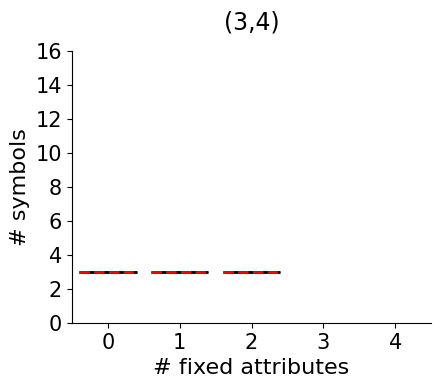

In [28]:
# Create a FacetGrid
g = seaborn.FacetGrid(pd.DataFrame(ml_dict), col="data set", col_wrap=3, sharey=True, height=4)
# Map the boxplot to each subplot in the grid
g.map(seaborn.boxplot, "level", "message length", order=range(5), showmeans=True, meanline=True, meanprops=dict(color="red", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
g.set_titles(col_template="{col_name}", fontsize=50)
g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
for ax in g.axes.flatten():
    ax.set_title(ax.get_title(), fontsize=17, y=1.05)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_ylim(0,16)
    ax.yaxis.set_ticks([0, 2, 4, 6, 8, 10, 12, 14, 16])
g.tight_layout()
plt.show()

This is uninformative in this toy example due to two main reasons: First, we have trained only one run, and so we cannot compute a mean and standard deviations. Second, after training, the message length arrived at the maximum message length, so we do not see any variation in this plot. This is just to showcase what can be done.